
  0%|          | 0/25 [00:00<?, ?it/s]

Epoch[1/25], G Loss: 3.1958, D Loss: 0.4152


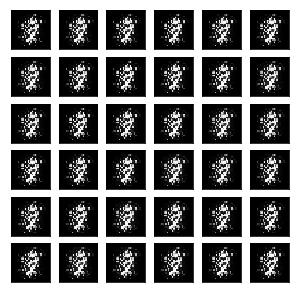


  4%|▍         | 1/25 [00:08<03:17,  8.24s/it]

Epoch[2/25], G Loss: 3.1585, D Loss: 0.3605


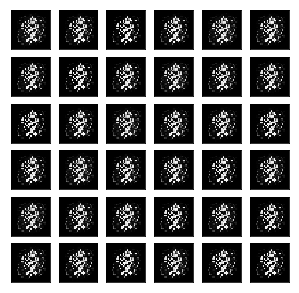


  8%|▊         | 2/25 [00:16<03:12,  8.39s/it]

Epoch[3/25], G Loss: 4.0513, D Loss: 0.3606


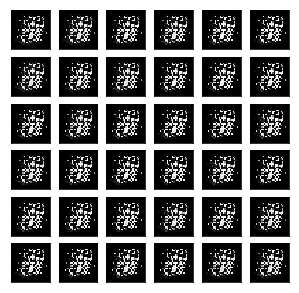


 12%|█▏        | 3/25 [00:25<03:07,  8.52s/it]

Epoch[4/25], G Loss: 4.9843, D Loss: 0.3374


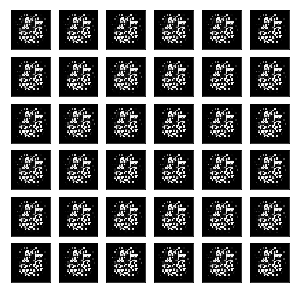


 16%|█▌        | 4/25 [00:35<03:04,  8.79s/it]

Epoch[5/25], G Loss: 6.2118, D Loss: 0.3294


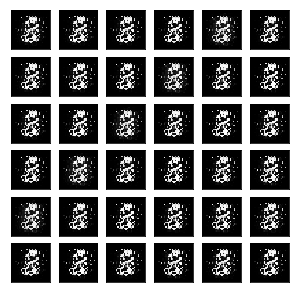


 20%|██        | 5/25 [00:44<02:59,  8.96s/it]

Epoch[6/25], G Loss: 6.0968, D Loss: 0.3223


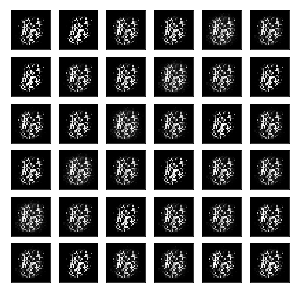


 24%|██▍       | 6/25 [00:54<02:53,  9.12s/it]

Epoch[7/25], G Loss: 4.2312, D Loss: 0.3499


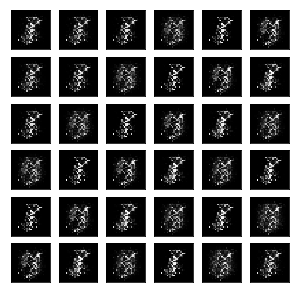


 28%|██▊       | 7/25 [01:04<02:45,  9.18s/it]

Epoch[8/25], G Loss: 3.6974, D Loss: 0.3609


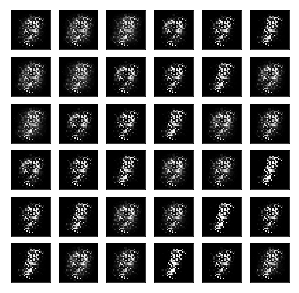


 32%|███▏      | 8/25 [01:13<02:37,  9.24s/it]

Epoch[9/25], G Loss: 4.4400, D Loss: 0.3481


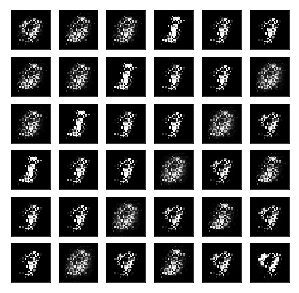


 36%|███▌      | 9/25 [01:23<02:27,  9.24s/it]

Epoch[10/25], G Loss: 4.4258, D Loss: 0.3656


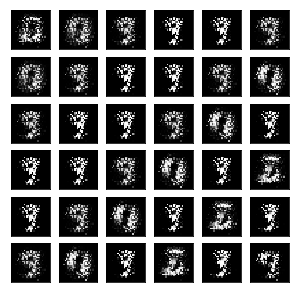


 40%|████      | 10/25 [01:32<02:19,  9.29s/it]

Epoch[11/25], G Loss: 5.6484, D Loss: 0.4078


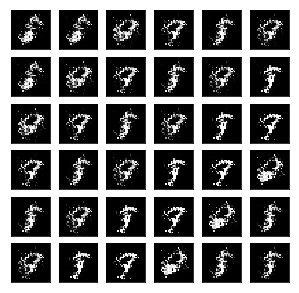


 44%|████▍     | 11/25 [01:42<02:10,  9.31s/it]

Epoch[12/25], G Loss: 5.0612, D Loss: 0.3610


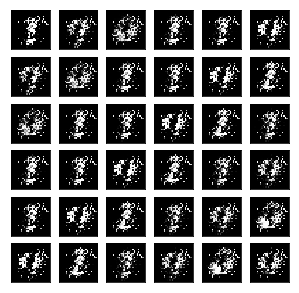


 48%|████▊     | 12/25 [01:52<02:02,  9.39s/it]

Epoch[13/25], G Loss: 5.3421, D Loss: 0.3370


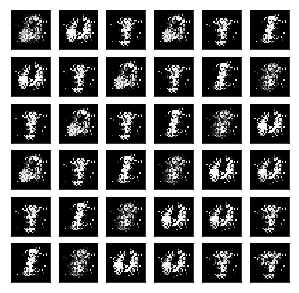


 52%|█████▏    | 13/25 [02:04<01:54,  9.57s/it]

Epoch[14/25], G Loss: 5.3649, D Loss: 0.3343


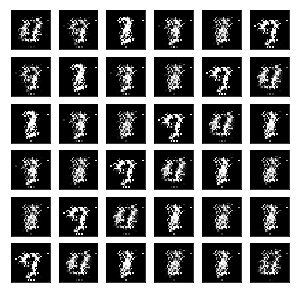


 56%|█████▌    | 14/25 [02:19<01:49,  9.93s/it]

Epoch[15/25], G Loss: 5.5412, D Loss: 0.3402


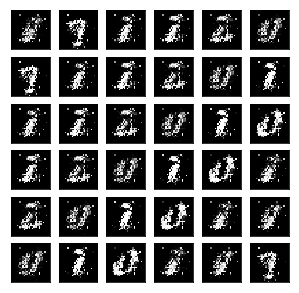


 60%|██████    | 15/25 [02:41<01:47, 10.78s/it]

Epoch[16/25], G Loss: 5.1184, D Loss: 0.3484


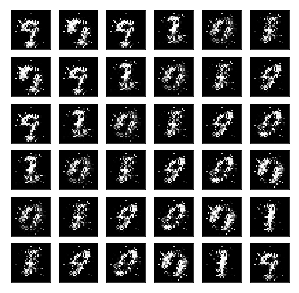


 64%|██████▍   | 16/25 [03:06<01:44, 11.66s/it]

Epoch[17/25], G Loss: 4.8936, D Loss: 0.3462


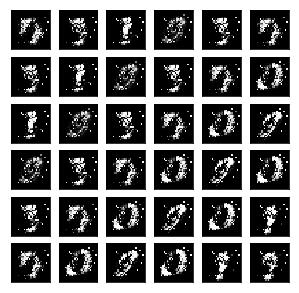


 68%|██████▊   | 17/25 [03:28<01:37, 12.25s/it]

Epoch[18/25], G Loss: 5.0609, D Loss: 0.3452


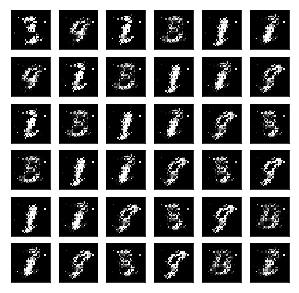


 72%|███████▏  | 18/25 [03:50<01:29, 12.79s/it]

Epoch[19/25], G Loss: 5.3004, D Loss: 0.3547


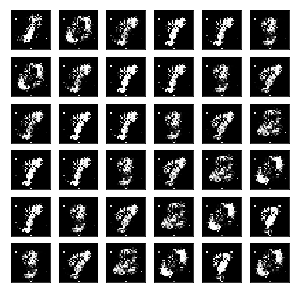


 76%|███████▌  | 19/25 [04:13<01:20, 13.34s/it]

Epoch[20/25], G Loss: 5.5561, D Loss: 0.3525


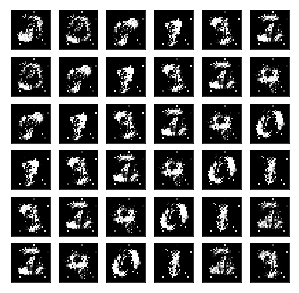


 80%|████████  | 20/25 [04:35<01:08, 13.79s/it]

Epoch[21/25], G Loss: 5.8140, D Loss: 0.3630


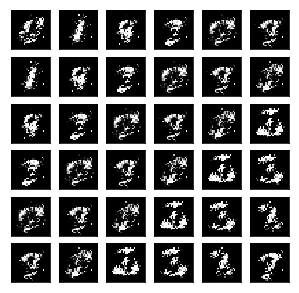


 84%|████████▍ | 21/25 [04:56<00:56, 14.14s/it]

Epoch[22/25], G Loss: 5.3879, D Loss: 0.3769


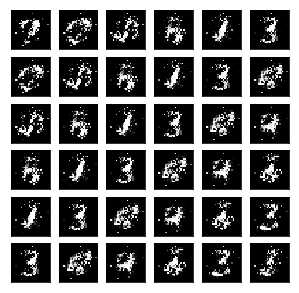


 88%|████████▊ | 22/25 [05:17<00:43, 14.43s/it]

Epoch[23/25], G Loss: 5.8255, D Loss: 0.3587


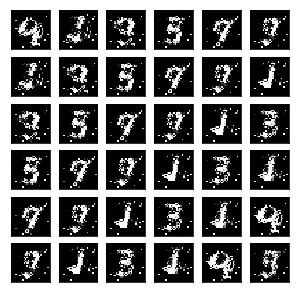


 92%|█████████▏| 23/25 [05:38<00:29, 14.72s/it]

Epoch[24/25], G Loss: 5.4876, D Loss: 0.3581


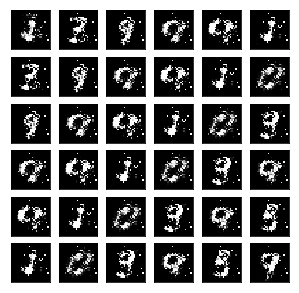


 96%|█████████▌| 24/25 [06:00<00:15, 15.02s/it]

Epoch[25/25], G Loss: 5.7810, D Loss: 0.3451


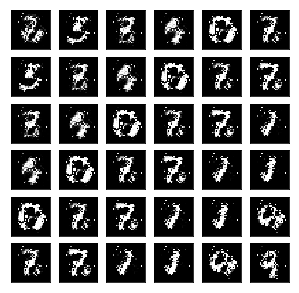


100%|██████████| 25/25 [06:21<00:00, 15.26s/it]


In [2]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('..')))
from src.ra_gan import *
    
# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

# Initialize model
model = RaNSGAN(image_size=784,
                hidden_dim=256,
                z_dim=128)

# Initialize trainer
trainer = RaNSGANTrainer(model=model,
                         train_iter=train_iter,
                         val_iter=val_iter,
                         test_iter=test_iter,
                         viz=True)

# Train
trainer.train(num_epochs=25,
              G_lr=2e-4,
              D_lr=2e-4,
              D_steps=1)